In [1]:
!pip3 install --upgrade pandas

  Using cached pandas-2.0.1-cp311-cp311-macosx_11_0_arm64.whl (10.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
modin 0.20.1 requires pandas==1.5.3, but you have pandas 2.0.1 which is incompatible.


In [2]:
import geopandas as gpd
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt

## 1. Data Ingest and Cleaning

In [3]:

cas = gpd.read_file('Boundaries - Community Areas (current).geojson')
with open("station_information.json", "r") as f:
    stations_data = json.load(f)
stations = pd.DataFrame(stations_data["data"]["stations"])
trips = pd.read_csv("202207-divvy-tripdata.csv")

In [4]:
cas = cas.rename(columns={"area_numbe" : "area_number"})
cas["area_number"] = cas["area_number"].astype("int")

In [5]:
geo = gpd.points_from_xy(stations["lon"], stations["lat"], crs = "EPSG:4326")
stations = gpd.GeoDataFrame(stations, geometry=geo)


In [6]:
trips["started_at"] = pd.to_datetime(trips["started_at"])
trips["ended_at"] = pd.to_datetime(trips["ended_at"])

start_point = gpd.points_from_xy(trips["start_lng"], trips["start_lat"], crs = "EPSG:4326")
end_point = gpd.points_from_xy(trips["end_lng"], trips["end_lat"], crs = "EPSG:4326")

trips = gpd.GeoDataFrame(trips, geometry=start_point)


In [7]:
# trips- geopandas, stations- geopandas, cas - geopandas
# cas.plot(), stations.plot(), trips.plot()


## 2. Spatial Aggregation

### a. Spatial Join  
### b. Add CAs to Trips

In [8]:
trips_start_point = gpd.GeoDataFrame(trips, geometry=start_point)
trips_end_point = gpd.GeoDataFrame(trips, geometry= end_point)

In [9]:
start_point_community_area = gpd.sjoin(trips_start_point, cas[["geometry", "area_number", "community"]], predicate="within")
end_point_community_area = gpd.sjoin(trips_end_point, cas[["geometry", "area_number", "community"]], predicate= "within")

In [10]:
start_point_community_area = start_point_community_area.rename(columns={"area_number" : "start_ca_num"})
end_point_community_area = end_point_community_area.rename(columns = {"area_number" : "end_ca_num"})

In [11]:
start_point_community_area = start_point_community_area.drop(columns='index_right')
end_point_community_area = end_point_community_area.drop(columns='index_right')

In [12]:
trips_b = gpd.sjoin(trips, start_point_community_area[["geometry", "start_ca_num", "community"]].drop_duplicates(),how = "left", predicate="intersects")
trips_b = trips_b.drop(columns= "index_right")
trips_b = gpd.GeoDataFrame(trips_b, geometry=end_point)
trips_b = gpd.sjoin(trips_b, end_point_community_area[["geometry", "end_ca_num", "community"]].drop_duplicates(), how = "left")
trips_b = trips_b.drop(columns = "index_right")
trips_b[200: 205]

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,geometry,start_ca_num,community_left,end_ca_num,community_right
200,82D5A9B008FEFCE6,docked_bike,2022-07-15 15:23:43,2022-07-15 15:56:17,Stetson Ave & South Water St,TA1308000029,Shedd Aquarium,15544,41.886835,-87.622320,41.867226,-87.615355,casual,POINT (-87.61535 41.86723),32.0,LOOP,33.0,NEAR SOUTH SIDE
201,D4859616FF0A9CA7,classic_bike,2022-07-10 11:20:04,2022-07-10 11:44:51,Adler Planetarium,13431,Shedd Aquarium,15544,41.866095,-87.607267,41.867226,-87.615355,member,POINT (-87.61536 41.86723),33.0,NEAR SOUTH SIDE,33.0,NEAR SOUTH SIDE
202,6647639132ADAF83,electric_bike,2022-07-22 17:29:30,2022-07-22 17:42:01,Narragansett & Irving Park,323,Mulligan Ave & Wellington Ave,351,41.950000,-87.790000,41.930000,-87.780000,member,POINT (-87.78000 41.93000),17.0,DUNNING,19.0,BELMONT CRAGIN
203,8F704DC5197EEF6A,classic_bike,2022-07-16 10:01:52,2022-07-16 10:10:18,Halsted St & Dickens Ave,13192,Sedgwick St & North Ave,TA1307000038,41.919936,-87.648830,41.911386,-87.638677,member,POINT (-87.63868 41.91139),7.0,LINCOLN PARK,7.0,LINCOLN PARK
204,4CD697748EE21B92,classic_bike,2022-07-05 14:06:59,2022-07-05 14:10:27,Halsted St & Dickens Ave,13192,Clifton Ave & Armitage Ave,TA1307000163,41.919936,-87.648830,41.918216,-87.656936,member,POINT (-87.65694 41.91822),7.0,LINCOLN PARK,7.0,LINCOLN PARK


In [13]:
# trips_b = pd.concat([trips, start_point_community_area[["ride_id", "start_ca_num"]], end_point_community_area[["ride_id", "end_ca_num"]]], axis = 1)

### c. Visualize Stations

<Axes: >

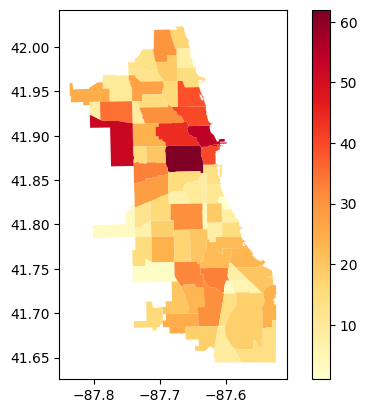

In [14]:
joined = gpd.sjoin(stations, cas, predicate='within')
station_counts = joined.groupby('area_number').size().reset_index(name='station_count')
cas_station_counts = cas.merge(station_counts, on='area_number', how='left')
cas_station_counts.plot(column='station_count', cmap='YlOrRd', legend=True)


In [15]:
len(start_point_community_area.columns)

16

### d. Visualize Trips 

In [16]:
# ebike = trip1_ca[trip1_ca['rideable_type']=='electric_bike']
# pedal_start = trip1_ca[trip1_ca['rideable_type']!= 'electric_bike'].groupby('start_ca_num').size().reset_index(name='pedal_start_count')
# pedal_end = trip1_ca[trip1_ca['rideable_type']!= 'electric_bike'].groupby('end_ca_num').size().reset_index(name='pedal_end_count')
# ebike_start = ebike.groupby('start_ca_num').size().reset_index(name='ebike_start_count')
# ebike_end = ebike.groupby('end_ca_num').size().reset_index(name='ebike_end_count')

In [17]:
start_pedal_counts = trips_b[trips_b["rideable_type"] != "electric_bike"].groupby("start_ca_num").size()
end_pedal_counts = trips_b[trips_b["rideable_type"] != "electric_bike"].groupby("end_ca_num").size()
start_electric_counts = trips_b[trips_b["rideable_type"] == "electric_bike"].groupby("start_ca_num").size()
end_electric_counts = trips_b[trips_b["rideable_type"] == "electric_bike"].groupby("end_ca_num").size()

In [18]:
# start_pedal_counts = trips_b[trips_b["rideable_type"] != "electric_bike"].groupby("start_ca_num")["start_ca_num"].count()
# end_pedal_counts = trips_b[trips_b["rideable_type"] != "electric_bike"].groupby("end_ca_num")["end_ca_num"].count()
# start_electric_counts = trips_b[trips_b["rideable_type"] == "electric_bike"].groupby("start_ca_num")["start_ca_num"].count()
# end_electric_counts = trips_b[trips_b["rideable_type"] == "electric_bike"].groupby("end_ca_num")["end_ca_num"].count()

In [19]:
start_trip_counts = start_pedal_counts.add(start_electric_counts , fill_value = 0)
end_trips_counts = end_pedal_counts.add(end_electric_counts, fill_value = 0)

In [20]:
percent_diff = ((start_pedal_counts + end_pedal_counts) - (start_electric_counts + end_electric_counts))/(start_electric_counts + end_electric_counts)

In [21]:
percent_diff = pd.DataFrame(percent_diff)
percent_diff = percent_diff.rename(columns= {0 : "diff"})
percent_diff = percent_diff.reset_index()

In [22]:
diff_join = cas.merge(percent_diff, left_on = "area_number",right_on = "index",  how = "outer")

In [23]:
#filling the nan values with -1 because the difference range is -1 to +1 missing values are considered as -1
diff_join["diff"].fillna(-1, inplace= True)

<Axes: >

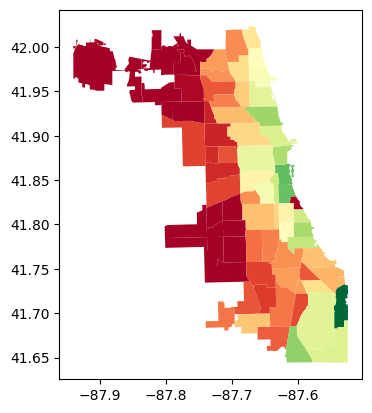

In [24]:
diff_join.plot(column = "diff",cmap='RdYlGn')

## 3. Trip Community Paths

### a. Bordering Areas

In [25]:
neighbor_communities = gpd.sjoin(cas.reset_index(), cas, how= "inner", predicate="intersects")
neighbor_communities = neighbor_communities[neighbor_communities["community_left"] != neighbor_communities["community_right"]]
# neighbor_communities[(neighbor_communities["community_left"] == "DOUGLAS") | (neighbor_communities["community_left"] == "GRAND BOULEVARD")]
neighbor_communities = neighbor_communities[neighbor_communities["shape_area_left"] > neighbor_communities["shape_area_right"]]
neighbor_communities

,index,community_left,area_left,shape_area_left,perimeter_left,area_num_1_left,area_number_left,comarea_id_left,comarea_left,shape_len_left,...,index_right,community_right,area_right,shape_area_right,perimeter_right,area_num_1_right,area_number_right,comarea_id_right,comarea_right,shape_len_right
0,0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,...,1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533
3,3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,...,1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533
4,4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,...,1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533
3,3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,...,0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098
33,33,NEAR SOUTH SIDE,0,49769639.4541,0,33,33,0,0,45053.1651038,...,0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,CHICAGO LAWN,0,98279465.1151,0,66,66,0,0,40073.0998382,...,68,ASHBURN,0,135460337.208,0,70,70,0,0,54818.1546317
70,70,BEVERLY,0,88779363.9384,0,72,72,0,0,44591.4851009,...,68,ASHBURN,0,135460337.208,0,70,70,0,0,54818.1546317
73,73,MORGAN PARK,0,91877340.6988,0,75,75,0,0,46396.419362,...,70,BEVERLY,0,88779363.9384,0,72,72,0,0,44591.4851009
70,70,BEVERLY,0,88779363.9384,0,72,72,0,0,44591.4851009,...,72,MOUNT GREENWOOD,0,75584290.0209,0,74,74,0,0,48665.1305392


### b. Graph Database Creation

In [26]:
from neo4j import GraphDatabase
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "Graph@123"))
# We also wish to define some helper functions to help us run queries with neo4j (based on functions by CJ Sullivan):

def run_query(query, parameters=None):
    session = None
    response = None
    try: 
        session = driver.session() 
        response = list(session.run(query, parameters))
    finally: 
        if session is not None:
            session.close()
    return response

def batch_query(query, df, batch_size=10000):
    # query can return whatever
    batch = 0
    results = []    
    while batch * batch_size < len(df):
        res = run_query(query, parameters={'rows': df.iloc[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        batch += 1
        results.extend(res)
        info = {"total": len(results), 
                "batches": batch}
        # print(info)
    return results

In [27]:
def add_communities(communities):

    query = '''UNWIND $rows AS row
    MERGE (c:Community {community: row.community})
    RETURN count(*) as total
    '''
    
    return batch_query(query, communities)

add_communities(cas[["community", "area_number"]])


[<Record total=77>]

In [28]:
def add_borders(neighbor_communities):
    # add borders to the community nodes
    query = '''UNWIND $rows as row
    MATCH(b:Community {community: row.community_left}), (c:Community {community: row.community_right})
    MERGE (b)-[:BORDERS]->(c)
    RETURN count(*) as total'''
    return batch_query(query, neighbor_communities)
add_borders(neighbor_communities[["community_left", "community_right"]])

[<Record total=197>]

### c. Compute Paths

In [29]:
trips_pedal = trips_b[(trips_b["rideable_type"] != "electric_bike") & (trips_b["start_ca_num"] != trips_b["end_ca_num"])]
trips_ebikes = trips_b[(trips_b["rideable_type"] == "electric_bike") & (trips_b["start_ca_num"] != trips_b["end_ca_num"])]

In [30]:
# trips_pedals = trips_pedal[:500]

In [31]:
grouped = trips_pedal.groupby(["community_left", "community_right"])
# grouped.get_group(list(grouped.groups)[0])
# .reset_index().drop_duplicates(subset=["start_ca_num", "end_ca_num"])

In [32]:
from collections import Counter
def shortest_path(start_end_communities):
    query = '''UNWIND $rows as row
    MATCH p=shortestPath((start:Community {community: row.community_left})-[*]-(end:Community {community: row.community_right}))
    WITH reduce(output= [], n IN nodes(p) | output + n) as nodecollection
    UNWIND nodecollection as eachNode
    return properties(eachNode)'''
    return batch_query(query, start_end_communities)

# path_and_communities = dict()
path_communities = []
for group_name, group in grouped:
    for record in (shortest_path(group[["community_left", "community_right"]].drop_duplicates())):
        path_communities.extend([com["community"] for com in record])

pedal_community_count = Counter(path_communities)


In [33]:
grouped1 = trips_ebikes.groupby(["community_left", "community_right"])

path_communities_ebikes = []
for group_name, group in grouped1:
    for record in (shortest_path(group[["community_left", "community_right"]].drop_duplicates())):
        path_communities_ebikes.extend([com["community"] for com in record])

ebike_community_count = Counter(path_communities_ebikes)

In [34]:
ebike_community_count

Counter({'ALBANY PARK': 59,
         'PORTAGE PARK': 117,
         'HERMOSA': 157,
         'AUSTIN': 101,
         'NORTH CENTER': 182,
         'AVONDALE': 61,
         'BELMONT CRAGIN': 81,
         'DUNNING': 48,
         'LINCOLN SQUARE': 220,
         'EDGEWATER': 67,
         'FOREST GLEN': 48,
         'HUMBOLDT PARK': 113,
         'IRVING PARK': 146,
         'JEFFERSON PARK': 36,
         'LAKE VIEW': 120,
         'LINCOLN PARK': 172,
         'LOGAN SQUARE': 238,
         'NEAR NORTH SIDE': 122,
         'LOOP': 99,
         'WEST TOWN': 330,
         'NEAR WEST SIDE': 440,
         'NORTH LAWNDALE': 130,
         'NORTH PARK': 46,
         'WEST RIDGE': 80,
         'ROGERS PARK': 48,
         'UPTOWN': 64,
         'ARCHER HEIGHTS': 27,
         'BRIGHTON PARK': 97,
         'GARFIELD RIDGE': 32,
         'WEST LAWN': 38,
         'CHICAGO LAWN': 46,
         'GAGE PARK': 81,
         'NEW CITY': 96,
         'SOUTH LAWNDALE': 90,
         'WEST ELSDON': 34,
         'AR

In [35]:
for_pedal_df = []
for community, count in pedal_community_count.items():
    for_pedal_df.append({'community_area': community, 'count': count})
pedal_count_df = pd.DataFrame(for_pedal_df)

for_ebike_df = []
for community, count in ebike_community_count.items():
    for_ebike_df.append({'community_area': community, 'count': count})
ebike_count_df = pd.DataFrame(for_ebike_df)


In [54]:
pedal_count_df

,community_area,count
0,ALBANY PARK,168.0
1,NORTH CENTER,748.0
2,AVONDALE,58.0
3,LINCOLN SQUARE,361.0
4,EDGEWATER,57.0
...,...,...
58,EAST SIDE,11014.0
59,HEGEWISCH,404.0
60,BRIGHTON PARK,NaN
61,GAGE PARK,NaN


In [36]:
same_community_trips_pedal = trips_b[(trips_b["rideable_type"] != "electric_bike") & (trips_b["start_ca_num"] == trips_b["end_ca_num"])]
same_community_trips_pedal_counts = same_community_trips_pedal.groupby("community_left").size().reset_index(name='same_community_count')
pedal_count_df["count"] +=  same_community_trips_pedal_counts["same_community_count"]
pedal_count_df

,community_area,count
0,ALBANY PARK,168.0
1,NORTH CENTER,748.0
2,AVONDALE,58.0
3,LINCOLN SQUARE,361.0
4,EDGEWATER,57.0
...,...,...
58,EAST SIDE,11014.0
59,HEGEWISCH,404.0
60,BRIGHTON PARK,NaN
61,GAGE PARK,NaN


In [37]:
same_community_trips_ebike = trips_b[(trips_b["rideable_type"] == "electric_bike") & (trips_b["start_ca_num"] == trips_b["end_ca_num"])]
same_community_trips_ebike_counts = same_community_trips_ebike.groupby("community_left").size().reset_index(name = "same_community_count")
ebike_count_df["count"] += same_community_trips_ebike_counts["same_community_count"]
ebike_count_df

,community_area,count
0,ALBANY PARK,325.0
1,PORTAGE PARK,173.0
2,HERMOSA,641.0
3,AUSTIN,152.0
4,NORTH CENTER,251.0
...,...,...
72,CLEARING,342.0
73,OHARE,NaN
74,NORWOOD PARK,NaN
75,HEGEWISCH,NaN


### d. Visualization

In [38]:
# ((start_pedal_counts + end_pedal_counts) - (start_electric_counts + end_electric_counts))/(start_electric_counts + end_electric_counts)

merged = ebike_count_df.merge(pedal_count_df, on= "community_area", how = "left")
merged = merged.rename(columns={"count_x" : "ebike_counts", "count_y" : "pedal_counts"})
merged["diff"] = ((merged["pedal_counts"] - merged["ebike_counts"]) / merged["ebike_counts"])
diff_join_4d = cas.merge(merged, left_on = "community", right_on = "community_area", how = "left")
diff_join_4d.head()

,community,area,shape_area,perimeter,area_num_1,area_number,comarea_id,comarea,shape_len,geometry,community_area,ebike_counts,pedal_counts,diff
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",DOUGLAS,130.0,539.0,3.146154
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",OAKLAND,1369.0,184.0,-0.865595
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",FULLER PARK,8003.0,447.0,-0.944146
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",GRAND BOULEVARD,229.0,21485.0,92.820961
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",KENWOOD,2580.0,1564.0,-0.393798


In [53]:
merged

,community_area,ebike_counts,pedal_counts,diff
0,ALBANY PARK,325.0,168.0,-0.483077
1,PORTAGE PARK,173.0,219.0,0.265896
2,HERMOSA,641.0,100.0,-0.843994
3,AUSTIN,152.0,116.0,-0.236842
4,NORTH CENTER,251.0,748.0,1.980080
...,...,...,...,...
72,CLEARING,342.0,NaN,NaN
73,OHARE,NaN,NaN,NaN
74,NORWOOD PARK,NaN,NaN,NaN
75,HEGEWISCH,NaN,404.0,NaN


In [39]:
diff_join.head()

,community,area,shape_area,perimeter,area_num_1,area_number,comarea_id,comarea,shape_len,geometry,index,diff
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",35.0,0.446029
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",36.0,-0.980241
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",37.0,-0.310105
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",38.0,-0.152532
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",39.0,0.120706


In [40]:
diff_join_4d["diff"].fillna(-1, inplace=True)

In [41]:
diff_join_4d["diff"]

0      3.146154
1     -0.865595
2     -0.944146
3     92.820961
4     -0.393798
        ...    
72    -0.700000
73    -0.999002
74    -1.000000
75    -0.803448
76    -1.000000
Name: diff, Length: 77, dtype: float64

<Axes: >

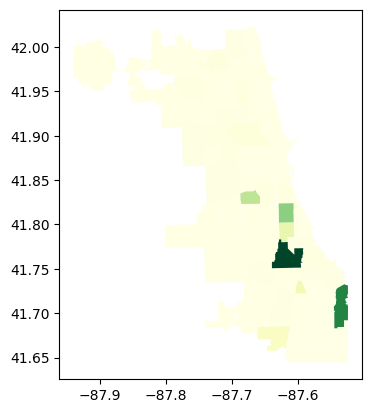

In [42]:
diff_join_4d["2d_3d_diff"] = diff_join["diff"] - diff_join_4d["diff"]
diff_join_4d.plot(column = "2d_3d_diff", cmap = "YlGn_r")

In [52]:
diff_join_4d["diff"].unique()

array([ 3.14615385e+00, -8.65595325e-01, -9.44145945e-01,  9.28209607e+01,
       -3.93798450e-01, -7.89994183e-01,  3.76096033e+01, -1.08619258e-02,
        3.69668246e-01, -8.89561271e-01, -1.00000000e+00, -9.70070423e-01,
        4.29787234e+00, -4.83076923e-01,  2.65895954e-01, -5.56291391e-01,
       -9.25925926e-03, -8.43993760e-01, -9.17261056e-01,  5.36301370e-01,
        6.88144330e-01,  5.12403101e+00, -2.36842105e-01, -9.84489625e-01,
        4.54545455e-01, -8.63937622e-01, -5.98265896e-01, -5.59210526e-01,
       -2.00000000e-01, -7.63336135e-01, -9.93243670e-01, -9.88475959e-01,
       -7.64705882e-01, -1.46341463e-01,  1.24790795e+00, -4.37500000e-01,
        1.36054422e-02,  9.09090909e-03,  2.93170732e+01,  6.65596026e+01,
       -7.00854701e-01, -9.79591837e-02, -4.11764706e-01,  1.98007968e+00,
       -9.42906574e-01, -9.02439024e-01,  1.56342857e+02,  1.76162791e+01,
        2.45994345e+00, -3.53706848e-01, -7.37113402e-01, -9.95371669e-01,
        2.06971264e+02, -

## 4. Temporal Analysis

### a. Hourly Intervals

In [43]:
trips_b = trips_b[trips_b["started_at"] <= trips_b["ended_at"]]
interval_array = pd.arrays.IntervalArray.from_arrays(trips_b["started_at"], trips_b["ended_at"])

In [44]:
hourly_intervals = pd.interval_range(start= pd.Timestamp("2022-07-01"), end = pd.Timestamp("2022-08-01"), freq="H")
# hourly_intervals = pd.DataFrame(hourly_intervals, columns=["start_hour"])
hourly_intervals

IntervalIndex([(2022-07-01, 2022-07-01 01:00:00], (2022-07-01 01:00:00, 2022-07-01 02:00:00], (2022-07-01 02:00:00, 2022-07-01 03:00:00], (2022-07-01 03:00:00, 2022-07-01 04:00:00], (2022-07-01 04:00:00, 2022-07-01 05:00:00] ... (2022-07-31 19:00:00, 2022-07-31 20:00:00], (2022-07-31 20:00:00, 2022-07-31 21:00:00], (2022-07-31 21:00:00, 2022-07-31 22:00:00], (2022-07-31 22:00:00, 2022-07-31 23:00:00], (2022-07-31 23:00:00, 2022-08-01]], dtype='interval[datetime64[ns], right]', length=744)

In [45]:
rental_counts = []
for interval in hourly_intervals:
    rental_counts.append(interval_array.overlaps(interval).sum())

In [46]:
hourly_intervals = pd.DataFrame({'num_rental_active' : rental_counts}, index=hourly_intervals.left)
hourly_intervals.head(10)

,num_rental_active
2022-07-01 00:00:00,399
2022-07-01 01:00:00,328
2022-07-01 02:00:00,198
2022-07-01 03:00:00,140
2022-07-01 04:00:00,113
2022-07-01 05:00:00,237
2022-07-01 06:00:00,598
2022-07-01 07:00:00,978
2022-07-01 08:00:00,1173
2022-07-01 09:00:00,1119


<Axes: >

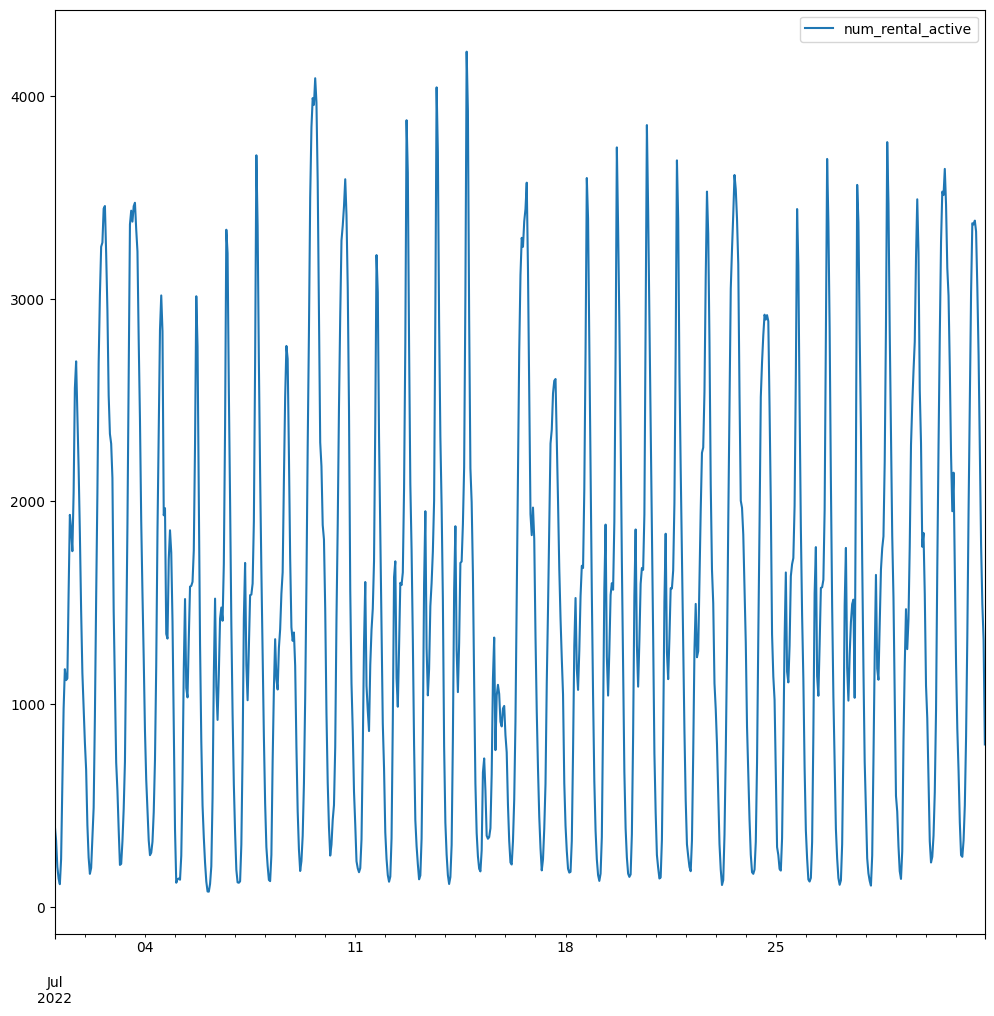

In [47]:
hourly_intervals.plot(column = "num_rental_active", kind = "line", figsize=(12,12))

## b. Resampled

<Axes: >

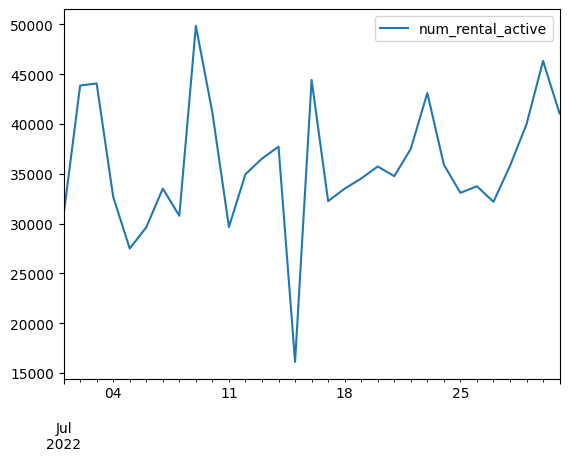

In [48]:
daily_intervals = pd.DataFrame(hourly_intervals["num_rental_active"].resample("D").sum())
# hourly_intervals.plot(kind = "line", column = "num_rental_active")
daily_intervals.plot(column = "num_rental_active", kind = "line")

## c. Questions

1) In the july month rentals are more on weekdays than weekends. Many number of people use divvy bikes to commute This explains the usage
2) It is actually showing the rentals of each day
3) on 15th July there are very less overlapping rentals. There maybe sevaral factors, the 15th falls on friday.

## Extra Credit

In [49]:
# !pip3 uninstall pandas
!pip3 install pandas==1.5.3

  Using cached pandas-1.5.3-cp311-cp311-macosx_11_0_arm64.whl (10.8 MB)


In [50]:
import pkg_resources
pkg_resources.require("pandas==1.5.3")
import modin.pandas as pd

ImportError: cannot import name 'Int64Index' from 'pandas' (/opt/homebrew/lib/python3.11/site-packages/pandas/__init__.py)